<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/paper-examples/1-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# Example 1. MNIST

Trains a fully connected neural network to identify handwritten digits using MNIST dataset.

## 1. Setup

Imports and defines the objects needed for this example.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

import deeptrack as dt
from deeptrack.extras import datasets
#Download dataset from the cloud
datasets.load("MNIST")

PATH_TO_DATASET = os.path.abspath("./datasets/MNIST")

TRAINING_SET_PATH = os.path.join(PATH_TO_DATASET, "training_set.npy")
TRAINING_LABELS_PATH = os.path.join(PATH_TO_DATASET, "training_labels.npy")
VALIDATION_SET_PATH = os.path.join(PATH_TO_DATASET, "validation_set.npy")
VALIDATION_LABELS_PATH = os.path.join(PATH_TO_DATASET, "validation_labels.npy")


Download Complete!
Extracting MNIST...


## 2. Defining the dataset

### 2.1 Loading the data

The dataset is how we provide the network with training data. For this example we create the dataset by loading it from storage using `LoadImage`.

In [2]:
# Load the images from storage
get_training_images = dt.LoadImage(path=TRAINING_SET_PATH)[..., np.newaxis]
get_training_labels = dt.LoadImage(path=TRAINING_LABELS_PATH)[..., np.newaxis]
get_validation_images = dt.LoadImage(path=VALIDATION_SET_PATH)[..., np.newaxis]
get_validation_labels = dt.LoadImage(path=VALIDATION_LABELS_PATH)[..., np.newaxis]

Note that we don't load the images yet, we have just created the objects that will do so. First we normalize the data.

In [3]:
normalization = dt.NormalizeMinMax(0, 1)

get_training_images >>= normalization
get_validation_images >>= normalization

Since all training data is contained in a single file, we explicitly load the images

In [4]:
training_images = get_training_images.resolve()
training_labels = get_training_labels.resolve()

validation_images = get_validation_images.resolve()
validation_labels = get_validation_labels.resolve()

We want to continuously generate new data for the network to train on. For this, we use the Dataset feature.

In [5]:
training_data_iterator = itertools.cycle(training_images)
training_label_iterator = itertools.cycle(training_labels)

training_iterator = dt.Dataset(
    data=training_data_iterator, 
    label=training_label_iterator
)

TypeError: TensorflowDataset.__init__() missing 1 required positional argument: 'dataset_name'

### 2.2 Augmenting the training set

In order to expand the dataset we augment it. 

Affine augmentations consist of translating, rescaling, rotating and shearing

In [ ]:
# How much to scale in x and y
scale = {
    "x": lambda: 0.8 + np.random.rand() * 0.4,
    "y": lambda: 0.8 + np.random.rand() * 0.4
}

# How much to translate in x and y
translate_px = {
    "x": lambda: int(np.random.randint(-2, 3)),
    "y": lambda: int(np.random.randint(-2, 3))
}

# Dummy property: whether to rotate or shear
should_rotate= lambda: np.random.randint(2)

# If should rotate, how much
rotate = lambda should_rotate: (-0.35 + np.random.rand() * 0.7) * should_rotate

# If not should rotate, how much shear
shear = lambda should_rotate: (-0.35 + np.random.rand() * 0.7) * (1 - should_rotate)

affine_transform = dt.Affine(
    scale=scale,
    translate_px=translate_px,
    should_rotate=should_rotate,
    # shear=shear,   
    order=2,
    mode="constant"
)

We also distort the images elastically.

In [ ]:
elastic_transform = dt.ElasticTransformation(
    alpha=lambda: np.random.rand() * 60, # Amplitude of distortions
    sigma=lambda: 5 + np.random.rand() * 2, # Granularity of distortions
    ignore_last_dim=True, # Last dimension is not a channel, so it should be augmented
    mode="constant"
)

Finally, since these distortions may cause pixels to fall outside the range of (0, 1), we clip the values.

In [ ]:
clip = dt.Clip(0, 1)

We add the augmentations to the pipeline

In [ ]:
augmentation = elastic_transform >> affine_transform >> clip
augmented_training_set = training_iterator >> augmentation

### 2.3 Defining the target
The training iterator resolves images. We can extract the label that we provided to the Dataset feature by just calling `get_property`.

In [ ]:
def get_label(image):
    return np.array(image.get_property("label")).squeeze()

### 2.3 Visualizing the dataset

To ensure the data and the labels match up we plot 8 images print their correspoding label. To convert the objects we created to an numpy array, we call the method `resolve()`. Since we flattened the images we need to reshape the images again to visualize them.

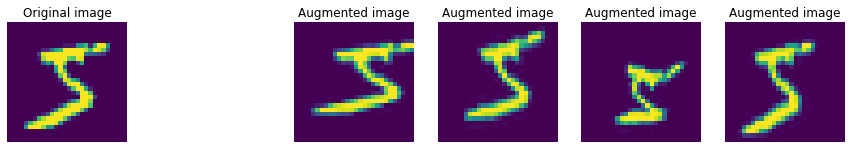

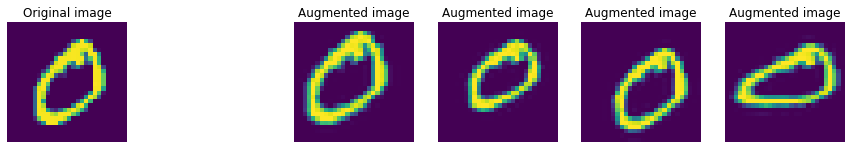

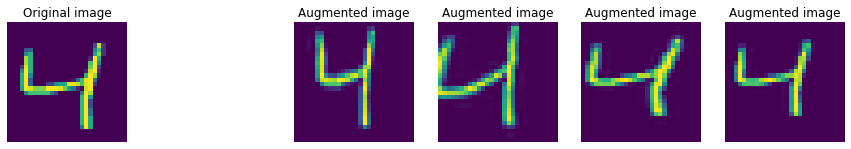

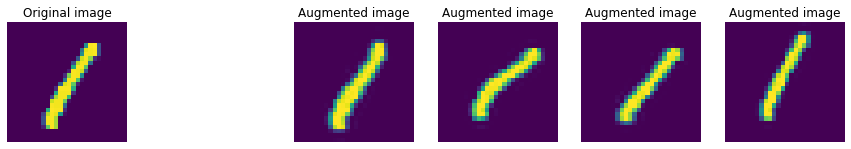

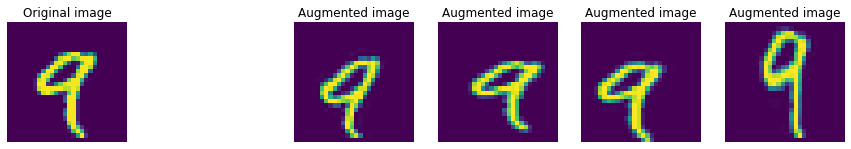

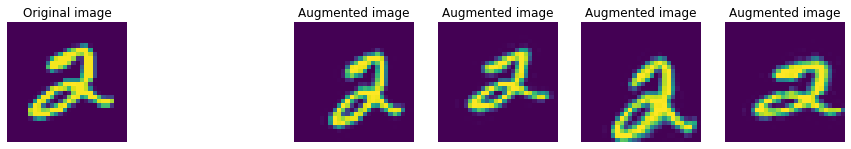

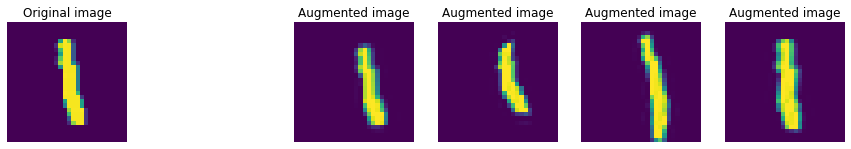

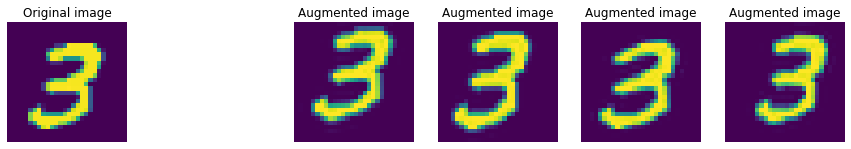

In [ ]:
NUMBER_OF_IMAGES = 8

for image_index in range(NUMBER_OF_IMAGES):
    
    augmented_training_set.update()
    
    original_image = training_iterator()
    
    
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title("Original image")
    
    for sub_plt in range(3, 7):
      # Only update the augmentation
      augmentation.update()
      augmented_image = augmented_training_set()
      plt.subplot(1, 6, sub_plt)
      plt.imshow(augmented_image)
      plt.axis('off')
      plt.title("Augmented image")
    
    plt.show()

## 3. Defining the network

The network used is a fully connected neural network. Here we define the network architecture, loss function and the optimizer.

In [ ]:
model = dt.models.FullyConnected(
    input_shape=(28, 28, 1),
    dense_layers_dimensions=(500, 500, 500, 500),
    number_of_outputs=10,
    dropout=(0.25, 0.25),
    output_activation="softmax",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer="rmsprop"
)

## 4. Training the network

The network is trained for 100 epochs using standard Keras syntax.

Generating 1001 / 1000 samples before starting training
Epoch 1/200
31/31 [==============================] - 8s 208ms/step - loss: 2.1959 - accuracy: 0.1995 - val_loss: 1.2029 - val_accuracy: 0.6060
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 1.5777 - accuracy: 0.4786 - val_loss: 0.9934 - val_accuracy: 0.6880
Epoch 3/200
31/31 [==============================] - 0s 10ms/step - loss: 1.2573 - accuracy: 0.5997 - val_loss: 0.6328 - val_accuracy: 0.8200
Epoch 4/200
31/31 [==============================] - 0s 9ms/step - loss: 0.9448 - accuracy: 0.6915 - val_loss: 0.6540 - val_accuracy: 0.7540
Epoch 5/200
31/31 [==============================] - 0s 9ms/step - loss: 0.7808 - accuracy: 0.7301 - val_loss: 0.4897 - val_accuracy: 0.8580
Epoch 6/200
31/31 [==============================] - 0s 8ms/step - loss: 0.5303 - accuracy: 0.8162 - val_loss: 0.5987 - val_accuracy: 0.8040
Epoch 7/200
31/31 [==============================] - 0s 10ms/step - loss: 0.4120 - accuracy: 0

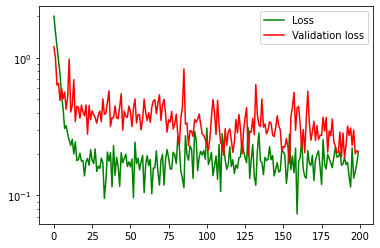

In [ ]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    generator = dt.generators.ContinuousGenerator(
        augmented_training_set & (augmented_training_set >> get_label),
        batch_size=32,
        min_data_size=1000,
        max_data_size=1001,
    )
    with generator:
        h = model.fit(
            generator,
            validation_data=(np.array(validation_images)[:500],
                            np.array(validation_labels)[:500].squeeze() ),
            epochs=200
        )
    
    plt.plot(h.history["loss"], 'g')
    plt.plot(h.history["val_loss"], 'r')
    plt.legend(["Loss", "Validation loss"])
    plt.yscale("log")
    plt.show()
    
else:
    model_path = datasets.load_model("MNIST")
    model.load_weights(model_path)

## 5. Evaluating the training


In [ ]:
array_of_images = validation_images
array_of_labels = validation_labels

predicted_digits = np.argmax(model.predict(array_of_images), axis=1)

accuracy = np.mean(np.array(array_of_labels) == predicted_digits)
print("Accuracy:", accuracy)
print("Error rate:", 1 - accuracy)

Accuracy: 0.10042534
Error rate: 0.89957466


### 5.1 Prediction vs actual

We show a few images, the true digit and the predicted digit

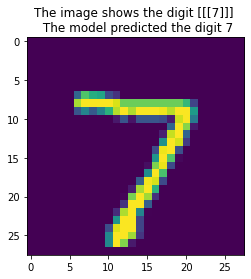

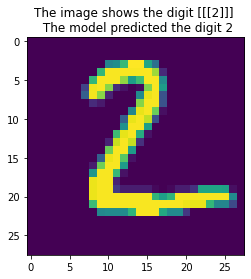

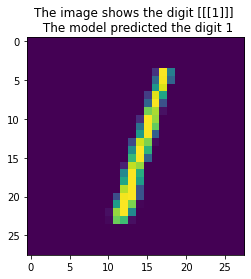

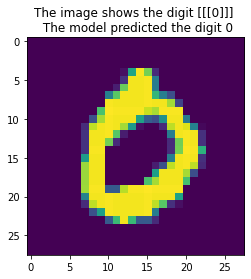

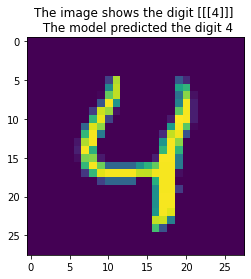

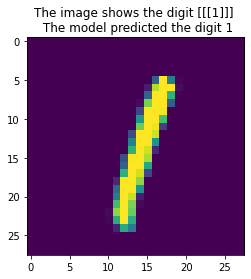

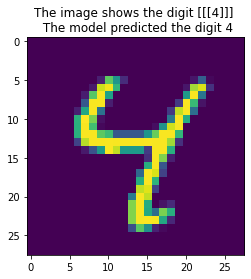

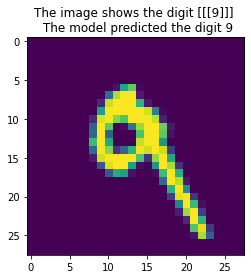

In [ ]:
NUMBER_OF_IMAGES = 8 
TITLE_STRING = "The image shows the digit {0} \n The model predicted the digit {1}"

for image_index in range(NUMBER_OF_IMAGES):
    image_to_show = np.reshape(array_of_images[image_index], (28, 28))
    plt.imshow(image_to_show)
    plt.title(TITLE_STRING.format(array_of_labels[image_index]._value, predicted_digits[image_index]))
    plt.show()

### 5.2 Visualizing errors

We show a few images which the model predicted incorrectly.

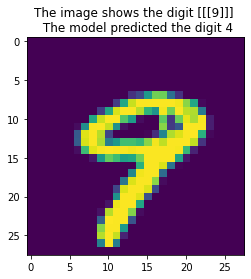

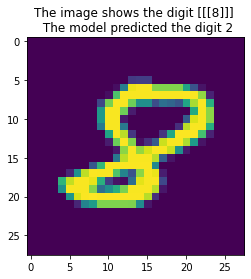

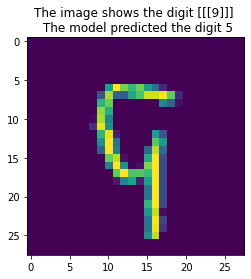

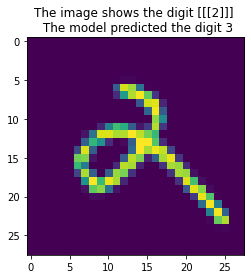

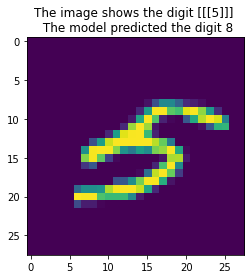

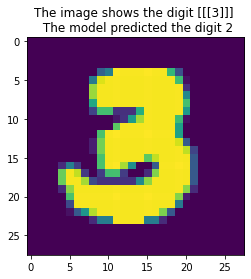

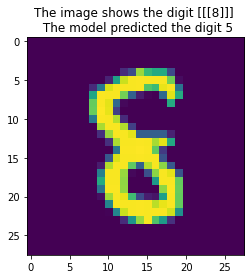

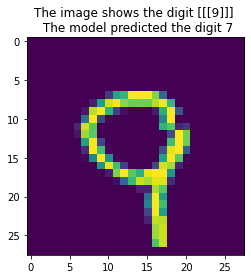

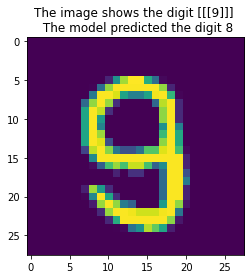

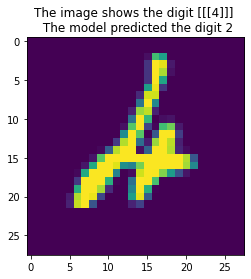

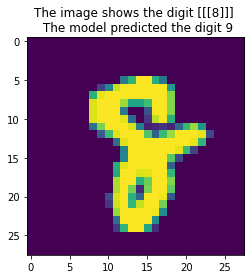

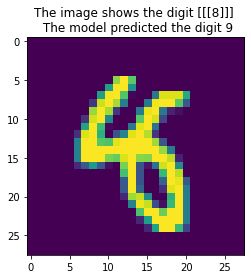

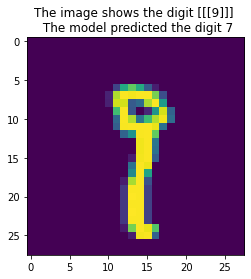

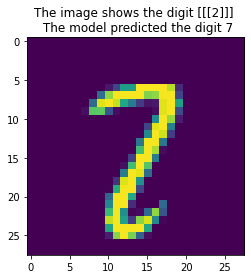

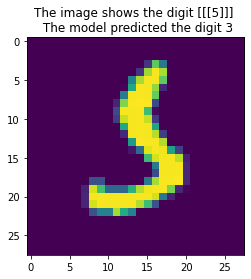

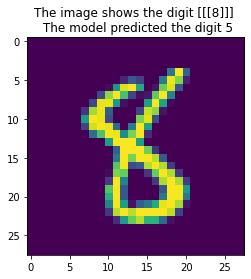

: 

In [ ]:
NUMBER_OF_IMAGES = 16

model_is_wrong = predicted_digits != array_of_labels.squeeze()

array_of_hard_images = array_of_images._value[model_is_wrong]
array_of_hard_labels = array_of_labels._value[model_is_wrong]
inaccurately_predicted_digits = predicted_digits[model_is_wrong]

for image_index in range(NUMBER_OF_IMAGES):
    image_to_show = np.reshape(array_of_hard_images[image_index], (28, 28))
    plt.imshow(image_to_show)
    plt.title(TITLE_STRING.format(array_of_hard_labels[image_index], inaccurately_predicted_digits[image_index]))
    plt.show()